In [73]:
from skimage.io import imread, imsave
from skimage.filters import gaussian, sobel
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import cv2
INVESTIGATION_PATH = 'ssim_bayer'
os.makedirs(INVESTIGATION_PATH, exist_ok=True)
get_path = lambda file: os.path.join(INVESTIGATION_PATH, file)



image = data.chelsea()

In [74]:
def rgb_to_bayer(image):
    h, w, c = image.shape
    bayer = np.zeros((h*2, w*2))
    bayer[0::2, 0::2] = image[..., 0]
    bayer[0::2, 1::2] = image[..., 1] / 2
    bayer[1::2, 0::2] = image[..., 1] / 2
    bayer[1::2, 1::2] = image[..., 2]
    return bayer

In [75]:
def bayer_to_rgb_bayer(image):
    rgb_bayer = np.zeros((*image.shape, 3))
    rgb_bayer[0::2, 0::2, 0] = image[0::2, 0::2]
    rgb_bayer[0::2, 1::2, 1] = image[0::2, 1::2]
    rgb_bayer[1::2, 0::2, 1] = image[1::2, 0::2]
    rgb_bayer[1::2, 1::2, 2] = image[1::2, 1::2]
    return rgb_bayer

In [76]:
bayer = rgb_to_bayer(image)
rgb_bayer = bayer_to_rgb_bayer(bayer)

imsave(get_path('bayer.png'), bayer)
imsave(get_path('rgb_bayer.png'), rgb_bayer)

Lossy conversion from float64 to uint8. Range [0.0, 231.0]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0.0, 231.0]. Convert image to uint8 prior to saving to suppress this warning.


In [77]:
def min_max_scaler(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [78]:
expectation = cv2.GaussianBlur(bayer, (11, 11), 1)
rgb_expectation = bayer_to_rgb_bayer(expectation)
imsave(get_path("gaussian_bayer.png"), expectation)
imsave(get_path("gaussian_bayer_scaled.png"), min_max_scaler(expectation))
imsave(get_path("rgb_gaussian_bayer.png"), rgb_expectation.astype(np.uint8))

Lossy conversion from float64 to uint8. Range [2.93987915218492, 145.74725701121045]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [79]:
flatten_rgb_expectation = rgb_expectation.flatten()
flatten_rgb_expectation = flatten_rgb_expectation[flatten_rgb_expectation != 0]


flatten_rgb_bayer = rgb_bayer.flatten()
flatten_rgb_bayer = flatten_rgb_bayer[flatten_rgb_bayer != 0]

In [80]:
def get_channels_from_bayer(image):
    r_channel = image[0::2, 0::2]
    g1_channel = image[0::2, 1::2]
    g2_channel = image[1::2, 0::2]
    b_channel = image[1::2, 1::2]
    return r_channel, g1_channel, g2_channel, b_channel

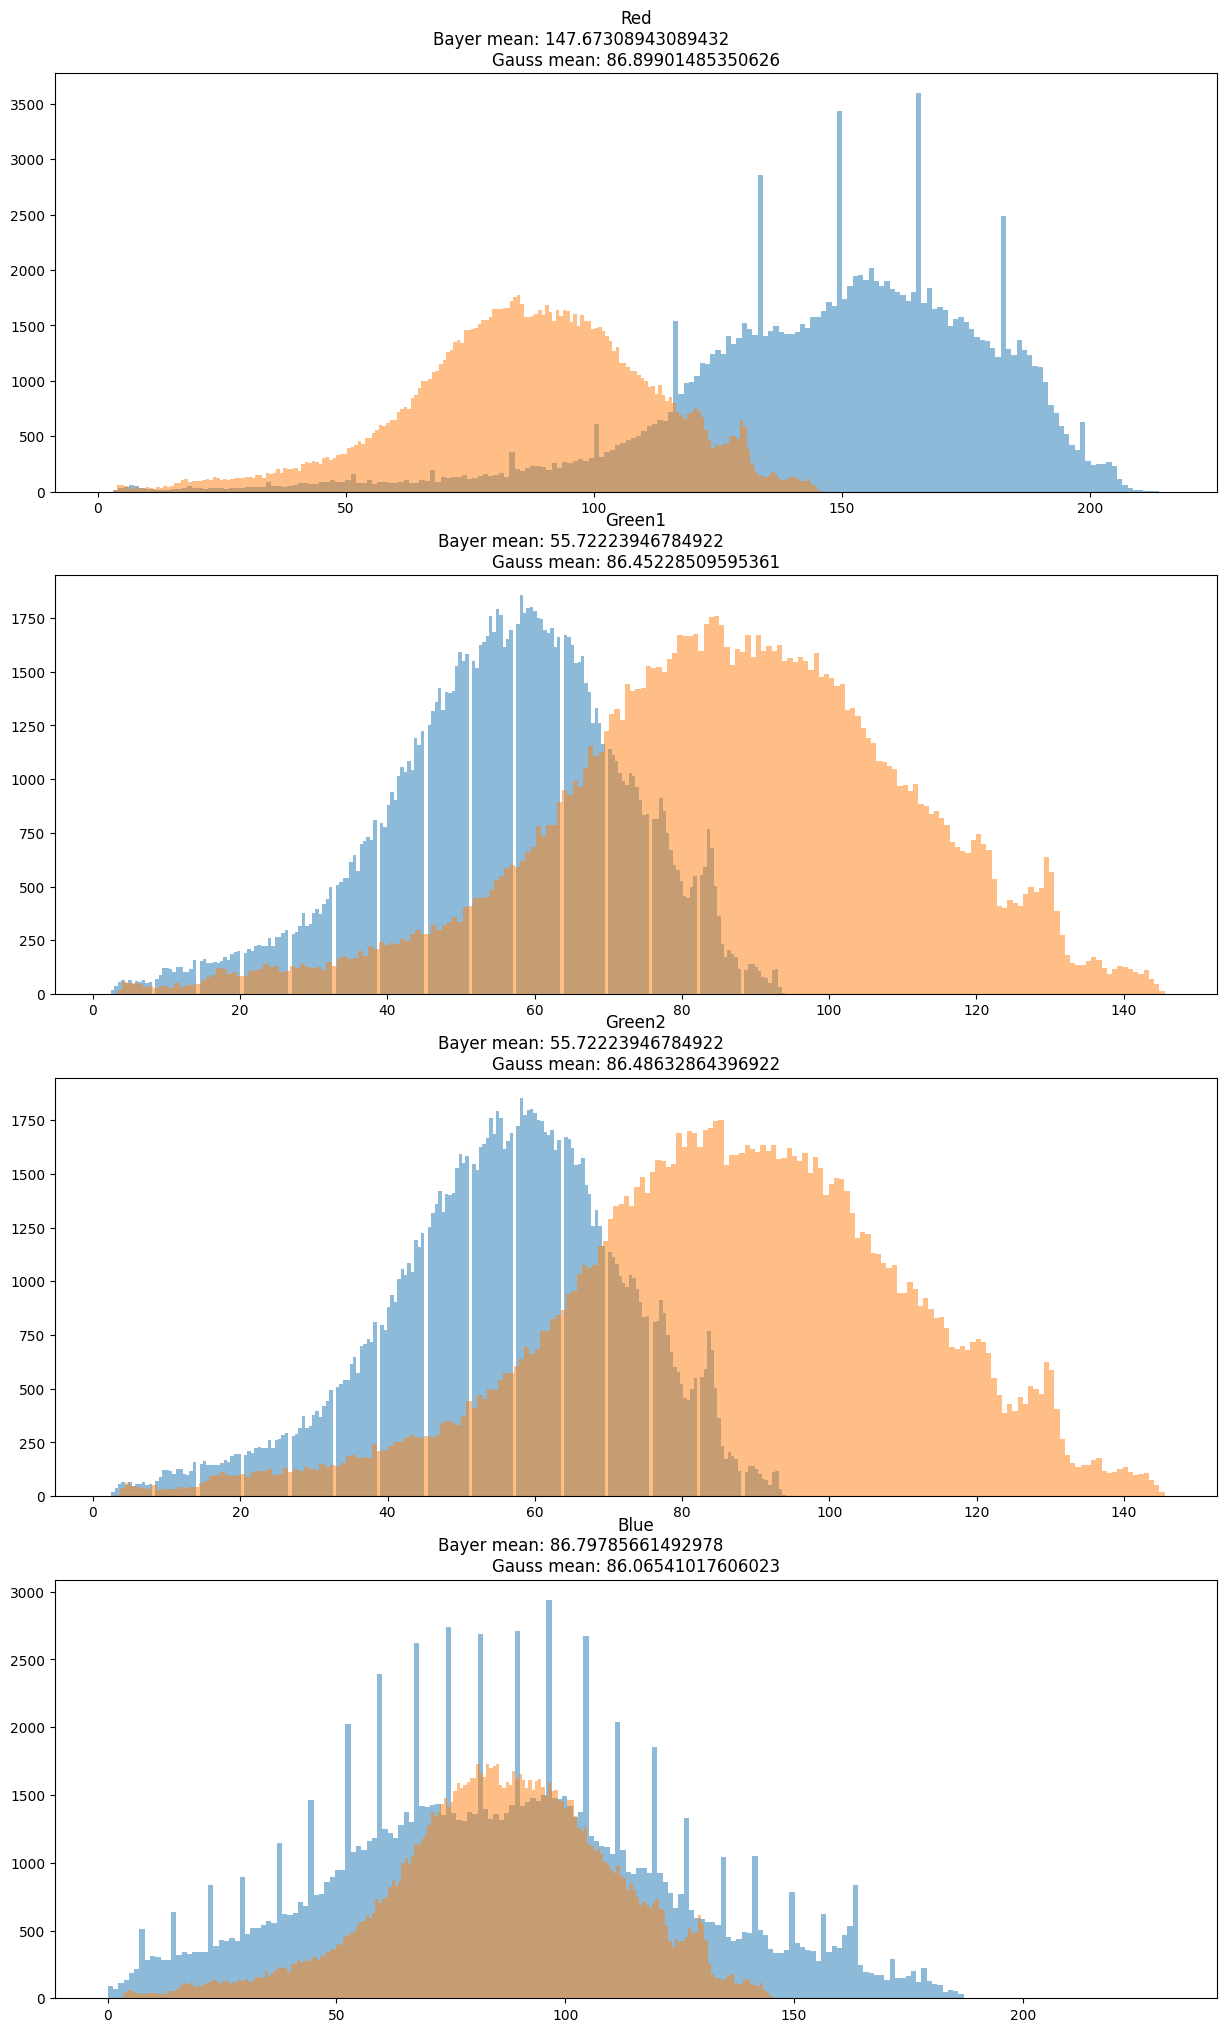

In [81]:
bayer_channels = get_channels_from_bayer(bayer)
expectation_channels = get_channels_from_bayer(expectation)


fig, ax = plt.subplots(nrows=4, figsize=(15, 25))



for i, (name, b_channel, e_channel) in enumerate(zip(['Red', 
                                       "Green1", 
                                       "Green2", 
                                       "Blue"],
                                       bayer_channels, expectation_channels)):
    ax[i].hist(b_channel.flatten(), bins=200, alpha=0.5)
    ax[i].hist(e_channel.flatten(), bins=200, alpha=0.5)   
    ax[i].set_title(name + f"\nBayer mean: {b_channel.mean()} \
                    \nGauss mean: {e_channel.mean()}")

plt.show()

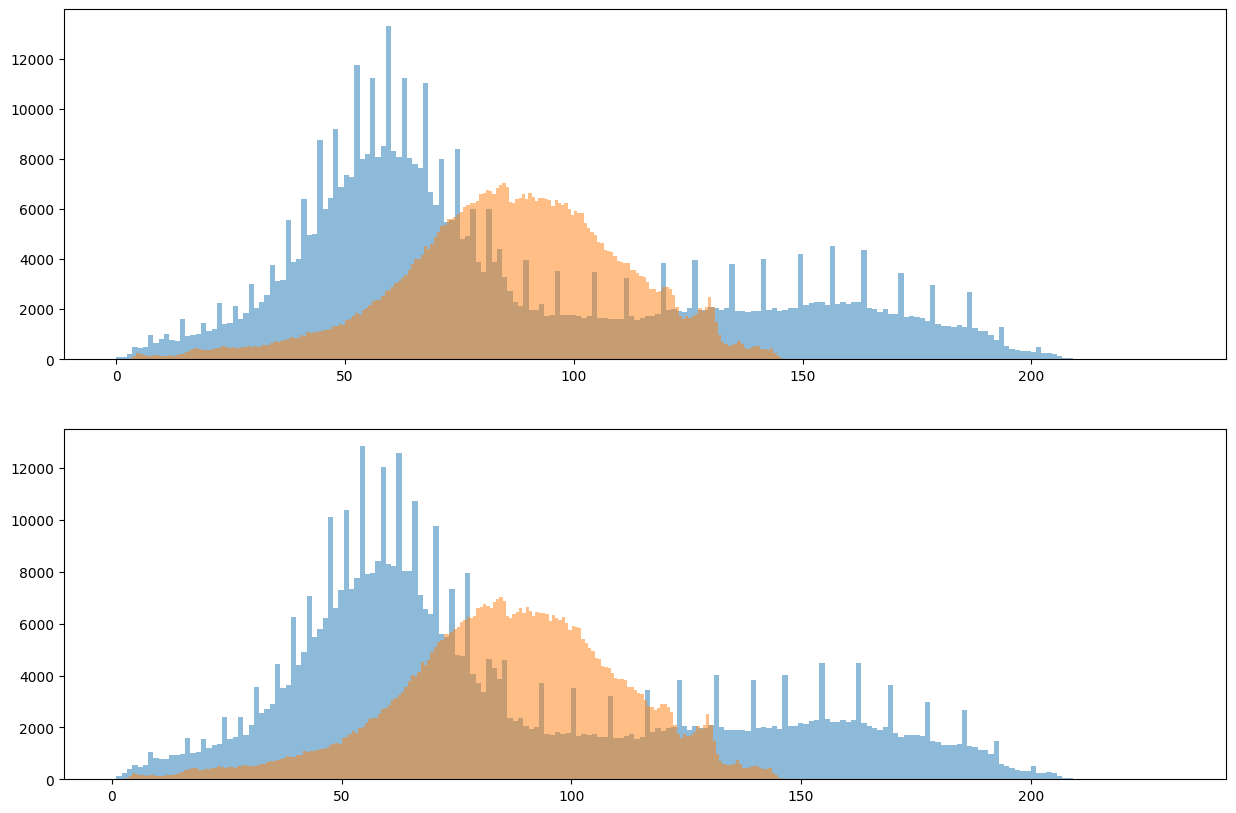

In [82]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 10))

axes[0].hist(bayer.flatten(), bins=200, alpha=0.5)
axes[0].hist(expectation.flatten(), bins=200, alpha=0.5)

axes[1].hist(flatten_rgb_bayer, bins=200, alpha=0.5)
axes[1].hist(flatten_rgb_expectation, bins=200, alpha=0.5)

plt.show()

In [83]:
downsample_shape = [int(s / 2) for s in bayer.shape]

downsampled_bayer = cv2.resize(bayer, tuple(downsample_shape)[::-1])
rgb_downsampled_bayer = bayer_to_rgb_bayer(downsampled_bayer)
imsave(get_path("downsampled_bayer.png"), downsampled_bayer)
imsave(get_path("downsampled_bayer_rgb.png"), rgb_downsampled_bayer)

Lossy conversion from float64 to uint8. Range [2.25, 145.75]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 145.75]. Convert image to uint8 prior to saving to suppress this warning.


c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


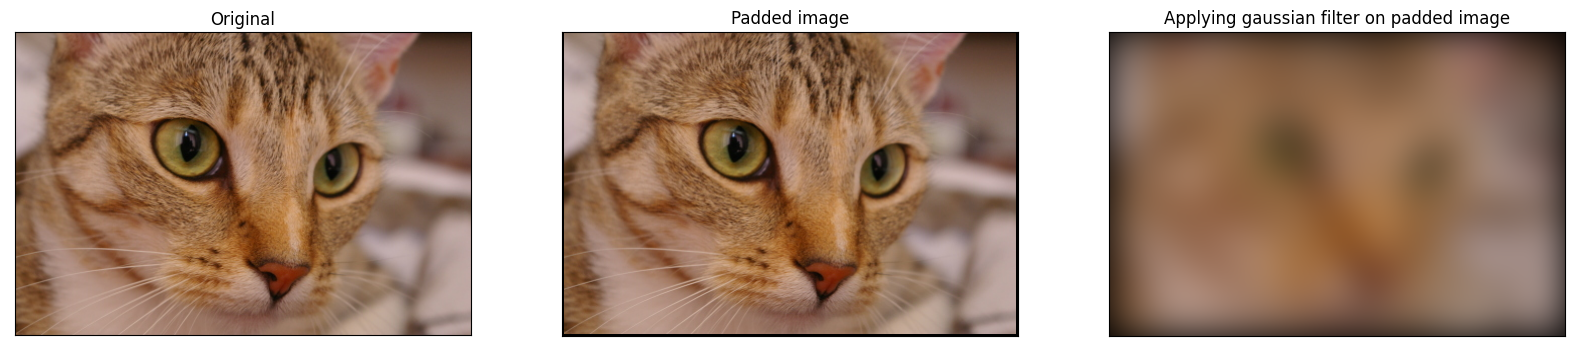

<Figure size 640x480 with 0 Axes>

In [84]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
axes[0].imshow(image)
axes[0].set_title('Original')
padded_image = np.pad(image, pad_width=((2, 2), (2, 2), (0, 0)), mode='constant')
axes[1].imshow(padded_image)
axes[1].set_title('Padded image')
axes[2].imshow(gaussian(padded_image, 20))
axes[2].set_title('Applying gaussian filter on padded image')
for ax in axes:
    ax.set_yticks([])
    ax.set_xticks([])
plt.show()
plt.savefig("Constant padding.png")

In [86]:
upsampled = cv2.resize(image, (bayer.shape[::-1]))

In [87]:
from skimage.color import rgb2yuv, yuv2rgb
import ipywidgets as widgets


@widgets.interact_manual(alpha=widgets.FloatSlider(value=0.1, min=0, max=1, step=0.001), save=False)
def add_hp(alpha: float=0, save=False):
    yuv_image = rgb2yuv(upsampled)
    yuv_image[..., 0] += alpha * expectation / 255

    with_hp = yuv2rgb(yuv_image)#.astype(np.uint8)

    difference = np.abs(with_hp - upsampled).mean()
    print(f"L1 difference {difference}")

    fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
    axes[0].imshow(upsampled)
    axes[1].imshow(with_hp)


    if save:
        imsave(get_path("initial.png"), upsampled)
        imsave(get_path(f"with_hp_{alpha}.png"), with_hp)
    plt.show()

interactive(children=(FloatSlider(value=0.1, description='alpha', max=1.0, step=0.001), Checkbox(value=False, …